### Delete when combining for final upload-------

In [2]:
# Import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Display options
pd.set_option('display.max_columns', None)

In [3]:
hr_employee = pd.read_csv( './Data/HR_Employee.csv', delimiter = ",")
Attrition = pd.read_csv( './Data/Attrition.csv', delimiter = ",")

In [4]:
X = hr_employee
Y = Attrition.values.ravel()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1176, 69) (1176,)
(294, 69) (294,)


### End Delete -------

#### Import packages for logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [30]:
# fit entire training data set using logistic model
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
pred = clf.predict(X_test)

In [36]:
metrics.accuracy_score(y_test, pred)

0.8571428571428571

In [37]:
metrics.confusion_matrix(y_test, pred)

array([[238,   9],
       [ 33,  14]])

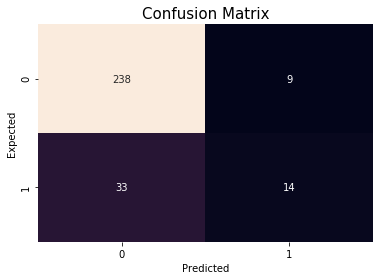

In [38]:
# Confusion Matrix
confusion_matrix =  pd.crosstab(index=y_test, columns=pred.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()